In [1]:
# import all packages needed for modeling
import pandas as pd
import numpy as np
import seaborn as sns
from feature_engine.encoding import OrdinalEncoder
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
from scipy.special import boxcox
from scipy.special import inv_boxcox
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb
import warnings
import pylab
from patsy import dmatrices

from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.decomposition import PCA

/Users/rachelfein/opt/anaconda3/envs/predictive-env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## End of preprocessing notebook, next notebook is modeling

In [2]:
# Import df from EDA & Preprocessing Notebook
X_train = pd.read_csv('Data/X_train_ol.csv')
X_test = pd.read_csv('Data/X_test_ol.csv')
y_train = pd.read_csv('Data/y_train_ol.csv')
y_test = pd.read_csv('Data/y_test_ol.csv')

# Baseline Model
The baseline model will be a Linear Regression model.

I will make a funtion to evaluate our model's performance. A breif overview of the different metrics:
- Mean Absolute Error (MAE): A basic metric that gives us the absolute difference between actual and predicted values. Idealy the final model would have a smaller MAE than the baseline model since we aim to lower the amount of error by tuning models.
- Mean Squared Error (MSE): Finds the squared difference between the actual and predicted values. The MSE is helpful since it avoids the cancellation of negative terms (unlike MAE). However, outliers will be more damaging since it penalizes the outliers more than MAE. 
- Root Mean Square Error(RMSE): Is the square root of the MSE. RMSE is easier to interpret than MSE since the output is in the same units as the variable

In [3]:
# need to set up standard scaler to transform predictions back to orginal form for interpretation

# make scaler for y_train
scaler_y = StandardScaler()
# make scaler for X_train
scaler = StandardScaler()

# fit X_train
scaler.fit(X_train)
# fit y_train
scaler_y.fit(y_train)

StandardScaler()

In [4]:
# function to view model's performance
def performance_metrics(model, X_test, y_test):
    
    # get prediction on X_train
    train_pred = model.predict(X_train)
    # get prediction on X_test
    # reshape to work with tree models
    train_pred = train_pred.reshape(-1,1)
    # inverse transform StandardScaler
    train_pred_inv_SS = scaler_y.inverse_transform(train_pred)
    # inverse transform BoxCox, lambda is from preprocessing notebook
    train_pred_inv_BC = (inv_boxcox(train_pred_inv_SS,-0.0207010))
    
    
    
    test_pred = model.predict(X_test)
    # reshape to work with tree models
    test_pred = test_pred.reshape(-1,1)
    # inverse transform StandardScaler
    test_pred_inv_SS = scaler_y.inverse_transform(test_pred)
    # inverse transform BoxCox, lambda is from preprocessing notebook
    test_pred_inv_BC = (inv_boxcox(test_pred_inv_SS,-0.0207010))
    
    print(f'Test Mean Absolute Error : {round(mean_absolute_error(y_test,test_pred_inv_BC),2)}')
    print(f'Test Mean Squared Error: {round(mean_squared_error(y_test,test_pred_inv_BC),2)}')
    print(f'Test Root Mean Square Error :$ {round(np.sqrt(mean_squared_error(y_test,test_pred_inv_BC)),2)}')
    print(f'Train Root Mean Square Error :$ {round(np.sqrt(mean_squared_error(y_train,train_pred_inv_BC)),2)}')

In [5]:
lr_base = LinearRegression()
lr_base.fit(X_train, y_train)

performance_metrics(lr_base, X_test, y_test)

Test Mean Absolute Error : 233.35
Test Mean Squared Error: 111676.51
Test Root Mean Square Error :$ 334.18
Train Root Mean Square Error :$ 2.07


To rely on a linear regression model it must meet the assumptions of linear regression. We will take a look at the assuptions next, 

In [6]:
# get residuals to look at assumptions of linear regression
test_pred = lr_base.predict(X_test)
residuals = y_test - test_pred

<AxesSubplot:ylabel='Density'>

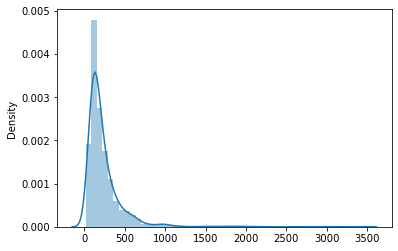

In [7]:
# look at normailty: the residuals of the Linear regression model are skewed
warnings.filterwarnings('ignore')
sns.distplot(residuals)

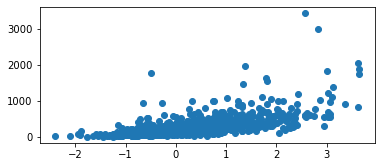

In [8]:
#The residuals do show a slight cone shape pattern 
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(test_pred, residuals)

In [9]:
# Double check for multicollinearity
X = X_train[['maximum_nights', 'availability_30', 'availability_365',
       'number_of_reviews', 'review_scores_rating',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location']]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                       feature       VIF
0               maximum_nights  1.007739
1              availability_30  1.268117
2             availability_365  1.270027
3            number_of_reviews  1.111386
4         review_scores_rating  3.491498
5    review_scores_cleanliness  2.255183
6        review_scores_checkin  2.052931
7  review_scores_communication  2.405259
8       review_scores_location  1.320121


We see the baseline model has a RMSE of 334 dollars indicates it is a very poor performing model. Since the average price overall is around 190 dollars, a error of 334 dollars is very off from the actual price.

## Model 2
For regression there are many different model types to choose from. Next, I am going to try a Random Forrest Model which is a little more robust to outliers than a Linear Regression model is. 

In [10]:
# Import Random Forest
forest_baseline = RandomForestRegressor()
forest_baseline.fit(X_train, y_train.values.ravel())

# view performance metrics
performance_metrics(forest_baseline, X_test, y_test)


Test Mean Absolute Error : 233.33
Test Mean Squared Error: 111981.0
Test Root Mean Square Error :$ 334.64
Train Root Mean Square Error :$ 3.27


The RandomForest model did not perform better than the linear regression model

In [11]:
# Use gridsearch to find a better RandomForest model
# I will start with a spread of different parameter options
param = {
    'criterion': ['squared_error'],
    'max_depth': [10, 50, 75],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [10, 30, 50],
    'min_samples_split': [2, 5, 10],
}

gridsearch_rf1 = GridSearchCV(estimator=forest_baseline,
                          param_grid=param, cv= 3, scoring='neg_mean_squared_error')

# Run search & takes a while to run
gridsearch_rf1.fit(X_train, y_train.values.ravel())
gridsearch_rf1.best_params_

{'criterion': 'squared_error',
 'max_depth': 75,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 2}

In [12]:
# view performance metrics
performance_metrics(gridsearch_rf1, X_test, y_test)

Test Mean Absolute Error : 235.49
Test Mean Squared Error: 127982.78
Test Root Mean Square Error :$ 357.75
Train Root Mean Square Error :$ 2.25


In [16]:
# to better understand how the different parameters performed we can visualize the data
results = pd.DataFrame(gridsearch_rf1.cv_results_)
results.sort_values(by='mean_test_score', ascending=False, inplace=True)
results.reset_index(drop=True, inplace=True)
print(results.shape)

results.head(2)

(54, 16)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.820353,0.010693,0.016310,0.000562,squared_error,75,auto,10,5,"{'criterion': 'squared_error', 'max_depth': 75...",-0.400907,-0.456423,-0.474814,-0.444048,0.031416,1
1,0.810430,0.009488,0.015656,0.000163,squared_error,50,auto,10,2,"{'criterion': 'squared_error', 'max_depth': 50...",-0.402161,-0.457773,-0.472313,-0.444082,0.030231,2


Text(0.5, 0, 'Hyperparameter combinations')

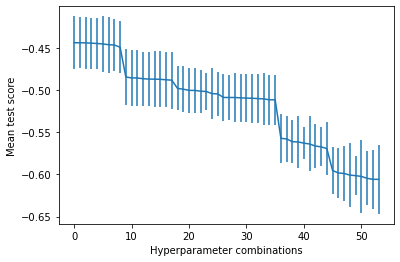

In [17]:
# plot model performance and error
results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean test score')
plt.xlabel('Hyperparameter combinations')

A little better than the baseline Randomforest model but still the linear regression model performed better.

## Model 4
XGBoost

In [13]:
# set up xgboost model
warnings.filterwarnings('ignore')

xgbr = xgb.XGBRegressor()
xgbr.fit(X_train, y_train)

performance_metrics(xgbr, X_test, y_test)


Test Mean Absolute Error : 232.89
Test Mean Squared Error: 111336.73
Test Root Mean Square Error :$ 333.67
Train Root Mean Square Error :$ 4.56


In [20]:
# block warning about deprecated int64
warnings.filterwarnings('ignore')

param_grid = {"max_depth":    [5, 6, 7],
              "n_estimators": [600, 700, 800],
              "learning_rate": [0.01, 0.015, 0.25]}

xgb_search = GridSearchCV(xgbr, param_grid, cv=3, scoring='neg_mean_squared_error').fit(X_train, y_train)

# Run search & takes a min or two
xgb_search.fit(X_train, y_train.values.ravel())
xgb_search.best_params_

{'learning_rate': 0.015, 'max_depth': 5, 'n_estimators': 800}

In [21]:
performance_metrics(xgb_search, X_test, y_test)

Test Mean Absolute Error : 233.5
Test Mean Squared Error: 112266.87
Test Root Mean Square Error :$ 335.06


In [14]:
# make basic decision tree model
from sklearn.tree import DecisionTreeRegressor

tree_baseline = DecisionTreeRegressor()
tree_baseline.fit(X_train, y_train)

performance_metrics(tree_baseline,X_test,y_test)

Test Mean Absolute Error : 231.81
Test Mean Squared Error: 110500.04
Test Root Mean Square Error :$ 332.42
Train Root Mean Square Error :$ 6.64


## Using Feature Selection to Improve Model
Feature selection algorithms can be seen as a combination of search techniques for suggesting which features to use in a model. In the Preprocessing notebook filter methods were used for feature selection, such as looking at corrilation. 

First atempt to use only the features with a significant F score for xgboost model and the linear regression model since those are our best performing models. Lastly, we will use the LASSO method which is an embedded feature selection method, meaning feature selection is performed during the modeling algorithm's execution. 

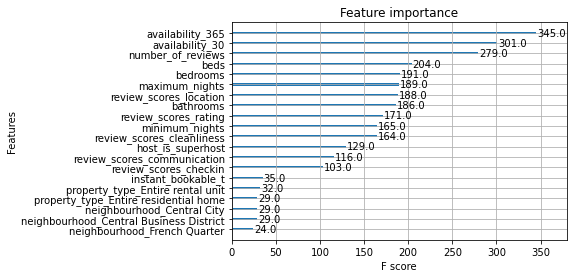

In [15]:
# view features of top importance for the xgboost model
from xgboost import plot_importance
plot_importance(xgbr, max_num_features=20)
plt.show()

In [16]:
# use SelectFromModel to find/select top features only
from sklearn.feature_selection import SelectFromModel
find_features = SelectFromModel(xgb.XGBRegressor(n_estimators=128, random_state=10))
find_features.fit(X_train, y_train)

SelectFromModel(estimator=XGBRegressor(base_score=None, booster=None,
                                       colsample_bylevel=None,
                                       colsample_bynode=None,
                                       colsample_bytree=None,
                                       enable_categorical=False, gamma=None,
                                       gpu_id=None, importance_type=None,
                                       interaction_constraints=None,
                                       learning_rate=None, max_delta_step=None,
                                       max_depth=None, min_child_weight=None,
                                       missing=nan, monotone_constraints=None,
                                       n_estimators=128, n_jobs=None,
                                       num_parallel_tree=None, predictor=None,
                                       random_state=10, reg_alpha=None,
                                       reg_lambda=None, scale_pos

In [17]:
# view how many features were selected, number of features were the coef is greater than the mean coef
selected_features = X_train.columns[(find_features.get_support())]
len(selected_features)

35

In [18]:
# 
# and now, let's compare the  amount of selected features with the amount of features which importance is above the
# mean importance, to make sure we understand the output of
# sklearn

print('total features: {}'.format((X_train.shape[1])))

print('selected features: {}'.format(len(selected_features)))

print(
    'features with coef greater than the mean coef: {}'.format(
        np.sum(find_features.estimator_.feature_importances_ >
               find_features.estimator_.feature_importances_.mean())))

total features: 127
selected features: 35
features with coef greater than the mean coef: 35


In [11]:
# make the performance fuction again this time using selecet_test
def performance_selection(model, select_test, y_test):
    
    # get prediction on X_train
    train_pred = model.predict(select_train)
    # get prediction on X_test
    # reshape to work with tree models
    train_pred = train_pred.reshape(-1,1)
    # inverse transform StandardScaler
    train_pred_inv_SS = scaler_y.inverse_transform(train_pred)
    # inverse transform BoxCox, lambda is from preprocessing notebook
    train_pred_inv_BC = (inv_boxcox(train_pred_inv_SS,-0.0207010))
    
    # get prediction on X_test
    test_pred = model.predict(select_test)
    # reshape to work with tree models
    test_pred = test_pred.reshape(-1,1)
    # inverse transform StandardScaler
    test_pred_inv_SS = scaler_y.inverse_transform(test_pred)
    # inverse transform BoxCox
    test_pred_inv_BC = (inv_boxcox(test_pred_inv_SS,-0.0207010))
    
    print(f'Test Mean Absolute Error : {round(mean_absolute_error(y_test,test_pred_inv_BC),2)}')
    print(f'Test Mean Squared Error: {round(mean_squared_error(y_test,test_pred_inv_BC),2)}')
    print(f'Test Root Mean Square Error :$ {round(np.sqrt(mean_squared_error(y_test,test_pred_inv_BC)),2)}')
    print(f'Train Root Mean Square Error :$ {round(np.sqrt(mean_squared_error(y_train,train_pred_inv_BC)),2)}')

In [30]:
# create X df for selected features
select_train = X_train[selected_features]
select_test = X_test[selected_features]

In [34]:
# view performance
performance_selection(xgbr, sel_test, y_test)

Test Mean Absolute Error : 232.71
Test Mean Squared Error: 111053.64
Test Root Mean Square Error :$ 333.25
Train Root Mean Square Error :$ 4.79


Using feature importance for XGB model did not help model performance. Next, lets try feature selection with the linear regression model

In [35]:
# try feature selection on linear regression model
sel_linear = SelectFromModel(LinearRegression())

sel_linear.fit(X_train, y_train)

SelectFromModel(estimator=LinearRegression())

In [36]:
# let's count the number of variables selected
selected_feat_linear = X_train.columns[(sel_linear.get_support())]

len(selected_feat_linear)

43

In [37]:
print('total features: {}'.format((X_train.shape[1])))

print('selected features: {}'.format(len(selected_feat_linear)))

print(
    'features with coefficients greater than the mean coefficient: {}'.format(
        np.sum(
            np.abs(sel_linear.estimator_.coef_) > np.abs(
                sel_linear.estimator_.coef_).mean())))

total features: 127
selected features: 43
features with coefficients greater than the mean coefficient: 43


In [40]:
# create X train and test for just selected features
select_train = X_train[selected_feat_linear]
select_test = X_test[selected_feat_linear]

In [41]:
# take a look the features that were selected
select_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3793 entries, 0 to 3792
Data columns (total 43 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   bathrooms                                       3793 non-null   float64
 1   bedrooms                                        3793 non-null   float64
 2   beds                                            3793 non-null   float64
 3   availability_30                                 3793 non-null   float64
 4   neighbourhood_Bayou St. John                    3793 non-null   float64
 5   neighbourhood_Bywater                           3793 non-null   float64
 6   neighbourhood_Leonidas                          3793 non-null   float64
 7   neighbourhood_Central Business District         3793 non-null   float64
 8   neighbourhood_Irish Channel                     3793 non-null   float64
 9   neighbourhood_French Quarter             

We see here that top important features are all categorical, this is a good indicator to why feature selection is hurting the models so bad. It is important to have some continious features in a predictive model. 

In [42]:
# fit selected features to linear regression model
linear_sel = LinearRegression()
linear_sel.fit(select_train, y_train)

# view performance of model
performance_selection(linear_sel, select_test, y_test)

Test Mean Absolute Error : 233.41
Test Mean Squared Error: 111808.9
Test Root Mean Square Error :$ 334.38
Train Root Mean Square Error :$ 1.99


We do not see an improvement in model performance 

In [43]:
# set up Lasso for linear regression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
lasso = SelectFromModel(Lasso(alpha=1, random_state=10))
lasso.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=1, random_state=10))

In [44]:
# make a list with the selected features and print the outputs
selected_feat = X_train.columns[(lasso.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(lasso.estimator_.coef_ == 0)))

total features: 127
selected features: 0
features with coefficients shrank to zero: 127


Lasso shows to be not helpful as all coefficients were shrank to zero but one variable. 

## Using filter method ANOVA 

<AxesSubplot:>

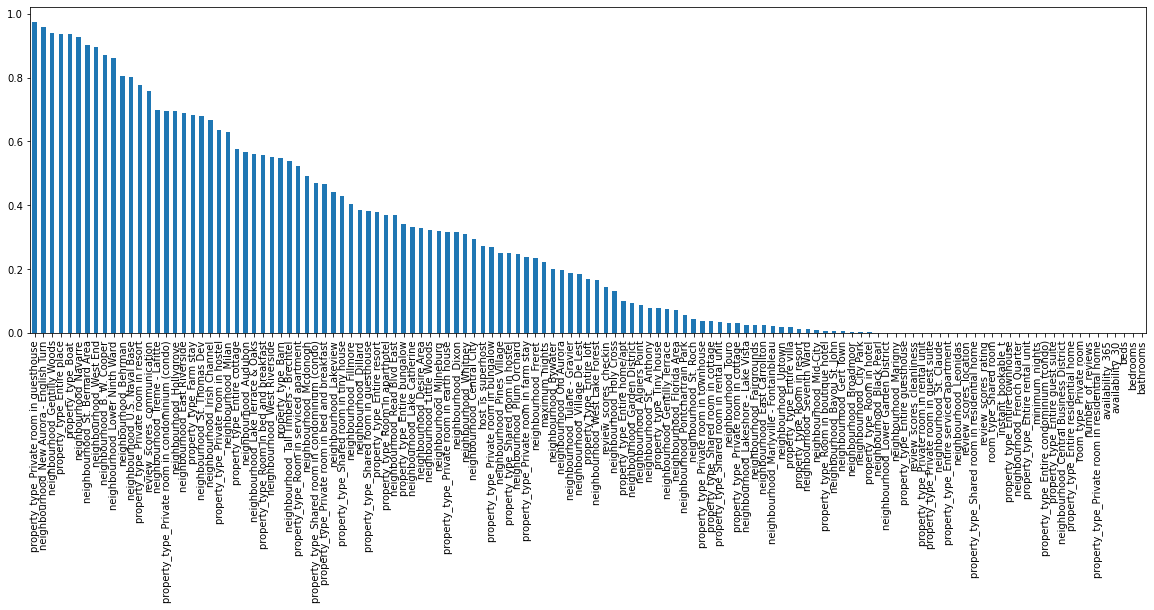

In [45]:
# Run ANOVA test to get a understanding of possible dependency 
anova = f_regression(X_train, y_train)

# plot values
anova = pd.Series(anova[1])
anova.index = X_train.columns
anova.sort_values(ascending=False).plot.bar(figsize=(20,6))

In [47]:
# select the top 20% of features based on dependancy
from sklearn.feature_selection import SelectKBest, SelectPercentile
percentile = SelectPercentile(f_regression,
                        percentile=20).fit(X_train, y_train)

# display selected feature names
precent20_cols = X_train.columns[percentile.get_support()]

In [48]:
# once again we see that many of these featuers are categorical
precent20_cols 

Index(['bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'availability_30',
       'availability_365', 'number_of_reviews', 'review_scores_rating',
       'review_scores_location', 'neighbourhood_Leonidas',
       'neighbourhood_Central Business District',
       'neighbourhood_French Quarter', 'neighbourhood_St. Claude',
       'property_type_Entire rental unit',
       'property_type_Entire residential home',
       'property_type_Private room in guest suite',
       'property_type_Private room in residential home',
       'property_type_Shared room in residential home',
       'property_type_Entire guest suite', 'property_type_Entire townhouse',
       'property_type_Entire condominium (condo)',
       'property_type_Private room in rental unit',
       'property_type_Entire serviced apartment', 'room_type_Private room',
       'room_type_Shared room', 'instant_bookable_t'],
      dtype='object')

In [ ]:
#0.10417087

In [51]:
# create X train and test for just selected features
select_train = X_train.drop(precent20_cols, axis=1)
select_test = X_test.drop(precent20_cols, axis=1)

In [56]:
# fit the selected features of linear regression
precent20 = LinearRegression()
precent20.fit(select_train, y_train)

performance_selection(precent20, select_test, y_test)

Test Mean Absolute Error : 234.22
Test Mean Squared Error: 113180.07
Test Root Mean Square Error :$ 336.42
Train Root Mean Square Error :$ 1.43


Feature selection methods have only hurt our model so far.

## Exploring other options
- Could be how we elimnated outliers was not the best way.
- Could be that adding another continous variable would help a lot like add how far from the airport or tourist attractions

In [58]:
# set up pca
pca_model = PCA(n_components=115)

# fit on X_train
pca_model.fit(X_train)

In [60]:
# 
np.sum(pca_model.explained_variance_ratio_)

0.9778788004122567

In [63]:
# get explained variance for X_train
explained_variance = []

for n in range(1,115):
    
    pca= PCA(n_components=n)
    pca.fit(X_train)
    
    explained_variance.append(np.sum(pca.explained_variance_ratio_))

Text(0, 0.5, 'Variance Explained')

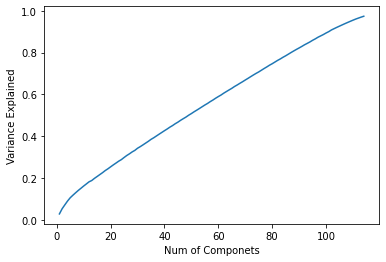

In [64]:
# view the explained variance for the different number of features
plt.plot(range(1,115), explained_variance)
plt.xlabel('Num of Componets')
plt.ylabel('Variance Explained')

In [71]:
# pick number of features to use for model based of of plot
pca_model_95 = PCA(n_components=95)

In [72]:
# create X train and test for just selected features
select_train = pca_model_95.fit_transform(X_train)
select_test = pca_model_95.transform(X_test)

In [74]:
# fit on linear regression model
lr_base.fit(select_train, y_train)

LinearRegression()

In [76]:
# view performance
performance_selection(lr_base, select_test, y_test)

Test Mean Absolute Error : 233.6
Test Mean Squared Error: 112195.27
Test Root Mean Square Error :$ 334.96
Train Root Mean Square Error :$ 1.82


### Removing neighboorhood data

Over half the columns is neighboorhoods we can see if there is any change if we dont take neighbourhood into account

In [12]:
# remove all neighboorhood columns for both test and train sets
select_train = X_train[X_train.columns.drop(list(X_train.filter(regex='neighbourhood')))]
select_test = X_test[X_test.columns.drop(list(X_test.filter(regex='neighbourhood')))]

In [13]:
# fit model
lr_base.fit(select_train, y_train)

# view performance 
performance_selection(lr_base, select_test, y_test)

Test Mean Absolute Error : 233.43
Test Mean Squared Error: 111835.18
Test Root Mean Square Error :$ 334.42
Train Root Mean Square Error :$ 2.16


In [14]:
select_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3793 entries, 0 to 3792
Data columns (total 61 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   host_is_superhost                                  3793 non-null   float64
 1   bathrooms                                          3793 non-null   float64
 2   bedrooms                                           3793 non-null   float64
 3   beds                                               3793 non-null   float64
 4   minimum_nights                                     3793 non-null   float64
 5   maximum_nights                                     3793 non-null   float64
 6   availability_30                                    3793 non-null   float64
 7   availability_365                                   3793 non-null   float64
 8   number_of_reviews                                  3793 non-null   float64
 9   review_s

In [15]:
# remove all neighboorhood columns for both test and train sets
select_train = select_train[select_train.columns.drop(list(select_train.filter(regex='property_type')))]
select_test = select_test[select_test.columns.drop(list(select_test.filter(regex='property_type')))]

In [16]:
select_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3793 entries, 0 to 3792
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_is_superhost            3793 non-null   float64
 1   bathrooms                    3793 non-null   float64
 2   bedrooms                     3793 non-null   float64
 3   beds                         3793 non-null   float64
 4   minimum_nights               3793 non-null   float64
 5   maximum_nights               3793 non-null   float64
 6   availability_30              3793 non-null   float64
 7   availability_365             3793 non-null   float64
 8   number_of_reviews            3793 non-null   float64
 9   review_scores_rating         3793 non-null   float64
 10  review_scores_cleanliness    3793 non-null   float64
 11  review_scores_checkin        3793 non-null   float64
 12  review_scores_communication  3793 non-null   float64
 13  review_scores_loca

In [17]:
# fit model
lr_base.fit(select_train, y_train)

# view performance 
performance_selection(lr_base, select_test, y_test)

Test Mean Absolute Error : 233.45
Test Mean Squared Error: 111892.77
Test Root Mean Square Error :$ 334.5
Train Root Mean Square Error :$ 1.98


In [18]:
select_train = select_train[select_train.columns.drop(list(select_train.filter(regex='availability_365')))]
select_test = select_test[select_test.columns.drop(list(select_test.filter(regex='availability_365')))]

In [19]:
# fit model
lr_base.fit(select_train, y_train)

# view performance 
performance_selection(lr_base, select_test, y_test)

Test Mean Absolute Error : 233.45
Test Mean Squared Error: 111883.78
Test Root Mean Square Error :$ 334.49
Train Root Mean Square Error :$ 1.98


In [20]:
select_train = select_train[select_train.columns.drop(list(select_train.filter(regex='beds')))]
select_test = select_test[select_test.columns.drop(list(select_test.filter(regex='beds')))]

In [21]:
# fit model
lr_base.fit(select_train, y_train)

# view performance 
performance_selection(lr_base, select_test, y_test)

Test Mean Absolute Error : 233.51
Test Mean Squared Error: 111965.09
Test Root Mean Square Error :$ 334.61
Train Root Mean Square Error :$ 1.93


In [22]:
select_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3793 entries, 0 to 3792
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_is_superhost            3793 non-null   float64
 1   bathrooms                    3793 non-null   float64
 2   bedrooms                     3793 non-null   float64
 3   minimum_nights               3793 non-null   float64
 4   maximum_nights               3793 non-null   float64
 5   availability_30              3793 non-null   float64
 6   number_of_reviews            3793 non-null   float64
 7   review_scores_rating         3793 non-null   float64
 8   review_scores_cleanliness    3793 non-null   float64
 9   review_scores_checkin        3793 non-null   float64
 10  review_scores_communication  3793 non-null   float64
 11  review_scores_location       3793 non-null   float64
 12  room_type_Private room       3793 non-null   float64
 13  room_type_Shared r

In [23]:
select_train = select_train[select_train.columns.drop(list(select_train.filter(regex='instant_bookable_t')))]
select_test = select_test[select_test.columns.drop(list(select_test.filter(regex='instant_bookable_t')))]

In [24]:
# fit model
lr_base.fit(select_train, y_train)

# view performance 
performance_selection(lr_base, select_test, y_test)

Test Mean Absolute Error : 233.51
Test Mean Squared Error: 111968.29
Test Root Mean Square Error :$ 334.62
Train Root Mean Square Error :$ 1.93


## Results
---
### Understanding why this model isnt good at making predictions

Relevant features: There could not be enough relevant data to build a preductive prediction model. We could try to add more relevant data such as adding more continious features. Some ideas could be distance to the airport, or distance to the top tourist destinations. More features can be added to this model using API to source this data from places such as Google Earth. 

Re-evalutating pre-processing steps: We know from pre-processing that most the continious features were skewed & far from normal. In hopes of making the data more normal I ilimnated outliers using IQR method removing the bottom and top 15% of outliers, this removed ### rows of data. As well, I used boxcox transformations to help with the skewness. Removing outliers is usally a last case sinero, but since this data was so skewed there was a possibility it could help. 

Noise: 

### What can we still learn from this analysis?

Use eda to narrow down location. Consider what the visuals represent. 
Would you rather have a house in a nicer neightboor hood, this can ilivate nuisense such as petty crime, conserned guests, negatives higher start up costs most likely, these clients will most likely be looking for nicer admenities and furnishings. 
Would you rather have a house that 


## Conclusion
---